In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../..")  # add parent directory to path
from lightning_toolbox import DataModule, TrainingModule
from lightning import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor
from ocd.models.permutation.utils import all_permutations, abbriviate_permutation
from ocd.data import SyntheticOCDDataset
from matplotlib import pyplot as plt
import copy
import random
import yaml
import wandb
# load and setup base configs
data_config = yaml.load(open('config/data.yaml'), Loader=yaml.FullLoader)['init_args']
model_config = yaml.load(open('config/model-simplified.yaml'), Loader=yaml.FullLoader)['init_args']
training_config = yaml.load(open('config/trainer.yaml'), Loader=yaml.FullLoader)

In [2]:
# utility functions
def set_model_config(n, model_config, num_transforms=3, num_layers=3, ordering=None):
    model_config = copy.deepcopy(model_config)
    if ordering is None:
        ordering = list(range(n))
    model_config["model_args"]["num_transforms"] = num_transforms
    model_config["model_args"]["layers"] = [n] * num_layers
    model_config["model_args"]["ordering"] = ordering
    model_config["model_args"]["in_features"] = n
    return model_config


def set_data_config(n, data_config, true_perm):
    data_config = copy.deepcopy(data_config)
    data_config["dataset_args"]["scm_generator_args"]["graph_generator_args"]["enforce_ordering"] = true_perm
    data_config["dataset_args"]["scm_generator_args"]["graph_generator_args"]["n"] = n
    return data_config


def describe_data(dataset, true_perm):
    dataset.scm.draw()
    data = dataset.samples.to_numpy()
    plt.title(f"SCM ${abbriviate_permutation(true_perm)}$")
    plt.show()
    for i in range(data.shape[1]):
        plt.hist(data[:, i], bins=100, density=True, alpha=0.5, label=f"$x_{i}$")
    plt.title(f"True permutation: ${abbriviate_permutation(true_perm)}$")
    plt.legend()
    plt.show()
    return dataset


def setup_datamodule(data_config):
    dataset = SyntheticOCDDataset(**data_config["dataset_args"])
    true_perm = data_config["dataset_args"]["scm_generator_args"]["graph_generator_args"]["enforce_ordering"]
    describe_data(dataset, true_perm)
    return DataModule(**{**data_config, "dataset": dataset})


def setup_logger_tensorboard(n, perm, true_perm, base_name):
    version = abbriviate_permutation(perm)
    return TensorBoardLogger(
        save_dir="lightning_logs", name=f"{base_name}-{n}", version=version if perm != true_perm else version + "-true"
    )


def setup_logger_wandb(n, perm, true_perm, base_name):
    version = abbriviate_permutation(perm)
    name = f"{base_name}-{n}/{version if perm != true_perm else version + '-true'}"
    return WandbLogger(project=f"fixed-simplified", name=name)


setup_logger = setup_logger_wandb


def test_fixed_permutations(n, data_config, model_config, training_config, seed=666, base_name="fixed"):
    all_perms = all_permutations(n)
    true_perm = all_perms[random.randint(0, n - 1)]  # pick a random permutation to be the true one
    dm = setup_datamodule(set_data_config(n, data_config, true_perm))
    for i, perm in enumerate(all_perms):
        seed_everything(seed)
        tm = TrainingModule(**set_model_config(n, model_config, ordering=perm))
        print(f"Training with permutation {perm}, true ordering is {true_perm}")
        if i == 0:
            print(tm)
        trainer = Trainer(
            **training_config,
            logger=setup_logger(n, perm, true_perm, base_name),
            callbacks=[LearningRateMonitor(logging_interval="step")],
        )
        trainer.fit(tm, dm)
        wandb.finish()


x(1) = exp(sigmoid(+0.20)) + exp(sigmoid(+0.35)) * N(0.35,0.64)
---------------------
x(0) = exp(sigmoid(x(1)*-0.83+-0.70)) + exp(sigmoid(x(1)*-0.33+-0.54)) * N(-0.54,0.23)
---------------------



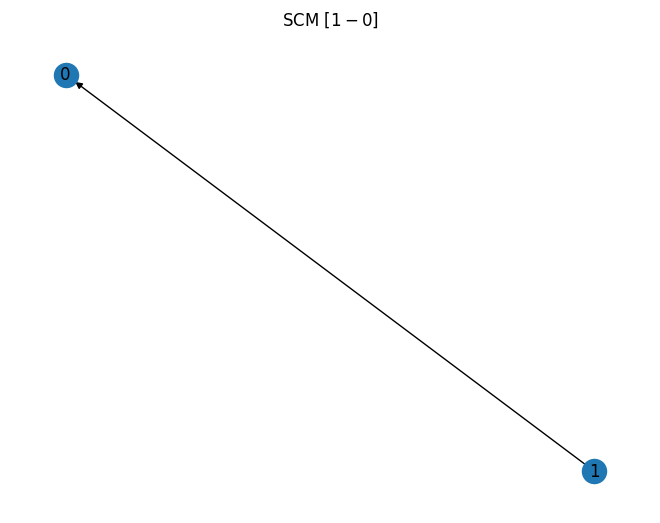

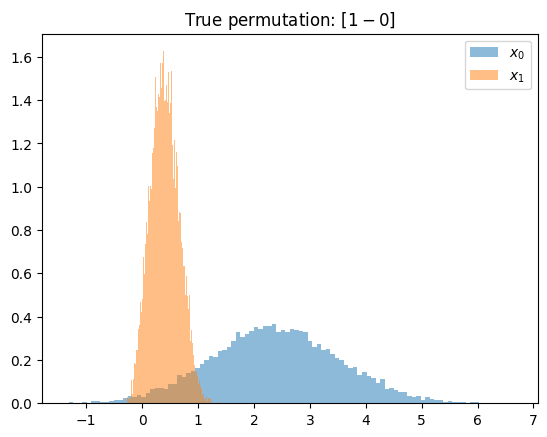

Global seed set to 666


Training with permutation [1, 0], true ordering is [1, 0]
TrainingModule(
  (model): OCDAF(
    (flows): ModuleList(
      (0): MaskedAffineFlow(
        (0): MaskedBlock(
          in_features=2, out_features=2, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): MaskedBlock(
          in_features=2, out_features=2, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (2): MaskedBlock(
          in_features=2, out_features=2, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (3): MaskedBlock(in_features=2, out_features=4, bias=True)
      )
      (1): MaskedAffineFlow(
        (0): MaskedBlock(
          in_features=2, out_features=2, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): MaskedBlock(
          in_features=2, out_features=2, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (2): MaskedBlock(
          in_f

wandb: Currently logged in as: vahidzee (ordered-causal-discovery). Use `wandb login --relogin` to force relogin


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 90    
--------------------------------
90        Trainable params
0         Non-trainable params
90        Total params
0.000     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁
loss/val,█▅▅▅▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▂▁▂▁▁▂▁▁▁▁▄▂▂▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁
nll/val,█▅▅▅▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▂▁▂▁▁▂▁▁▁▁▄▂▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-2.51701


Global seed set to 666


Training with permutation [0, 1], true ordering is [1, 0]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 90    
--------------------------------
90        Trainable params
0         Non-trainable params
90        Total params
0.000     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/val,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-2.32496


x(1) = exp(sigmoid(+0.20)) + exp(sigmoid(+0.35)) * N(0.35,0.64)
---------------------
x(2) = exp(sigmoid(x(1)*-0.83+-0.70)) + exp(sigmoid(x(1)*-0.33+-0.54)) * N(-0.54,0.23)
---------------------
x(0) = exp(sigmoid(x(2)*-0.53+-0.67)) + exp(sigmoid(x(2)*-0.93+0.51)) * N(0.51,0.25)
---------------------



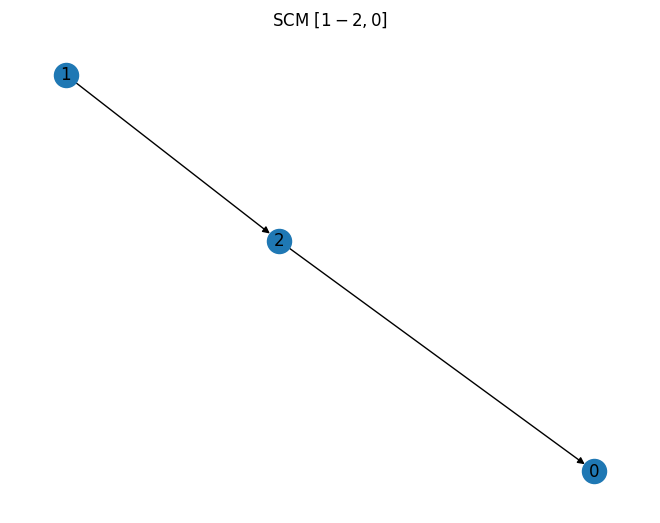

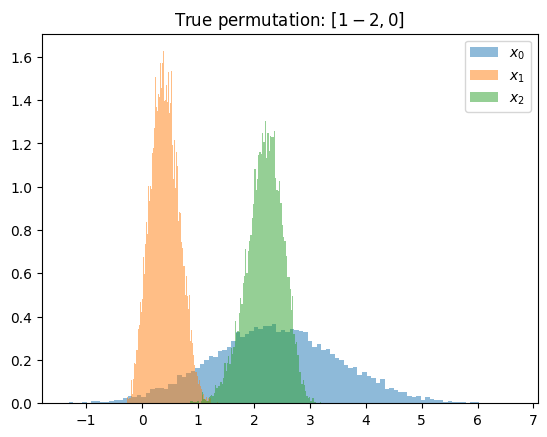

Global seed set to 666


Training with permutation [2, 1, 0], true ordering is [1, 2, 0]
TrainingModule(
  (model): OCDAF(
    (flows): ModuleList(
      (0): MaskedAffineFlow(
        (0): MaskedBlock(
          in_features=3, out_features=3, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): MaskedBlock(
          in_features=3, out_features=3, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (2): MaskedBlock(
          in_features=3, out_features=3, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (3): MaskedBlock(in_features=3, out_features=6, bias=True)
      )
      (1): MaskedAffineFlow(
        (0): MaskedBlock(
          in_features=3, out_features=3, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): MaskedBlock(
          in_features=3, out_features=3, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (2): MaskedBlock(
        

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 180   
--------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
loss/val,█▇▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
nll/val,█▇▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-3.48111


Global seed set to 666


Training with permutation [1, 2, 0], true ordering is [1, 2, 0]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 180   
--------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂
loss/val,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂
nll/val,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-2.55645


Global seed set to 666


Training with permutation [1, 0, 2], true ordering is [1, 2, 0]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 180   
--------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/val,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-3.98802


Global seed set to 666


Training with permutation [2, 0, 1], true ordering is [1, 2, 0]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 180   
--------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▃▁▁▁▁▁
loss/val,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▃▁▁▁▁▁
nll/val,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-5.60395


Global seed set to 666


Training with permutation [0, 2, 1], true ordering is [1, 2, 0]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 180   
--------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▂▂▁▁▁▁▂▂▂▁▁▁▁
loss/val,█▆▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▂
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▂▂▁▁▁▁▂▂▂▁▁▁▁
nll/val,█▆▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▂▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-4.93265


Global seed set to 666


Training with permutation [0, 1, 2], true ordering is [1, 2, 0]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 180   
--------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▃▁▁▁▁▁
loss/val,█▆▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▂▁▁▂
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▃▁▁▁▁▁
nll/val,█▆▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▂▁▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-6.90924


x(2) = exp(sigmoid(+0.20)) + exp(sigmoid(+0.35)) * N(0.35,0.64)
---------------------
x(1) = exp(sigmoid(x(2)*-0.83+-0.70)) + exp(sigmoid(x(2)*-0.33+-0.54)) * N(-0.54,0.23)
---------------------
x(0) = exp(sigmoid(x(1)*-0.53+-0.67)) + exp(sigmoid(x(1)*-0.93+0.51)) * N(0.51,0.25)
---------------------
x(3) = exp(sigmoid(x(0)*0.22+-0.77)) + exp(sigmoid(x(0)*-0.66+0.32)) * N(0.32,0.20)
---------------------



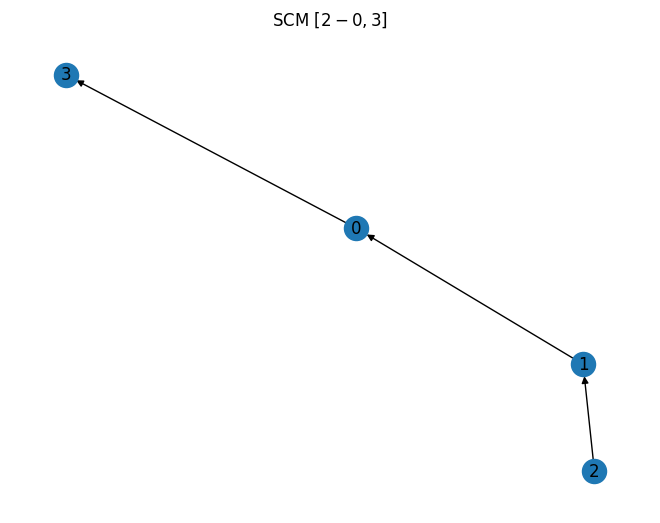

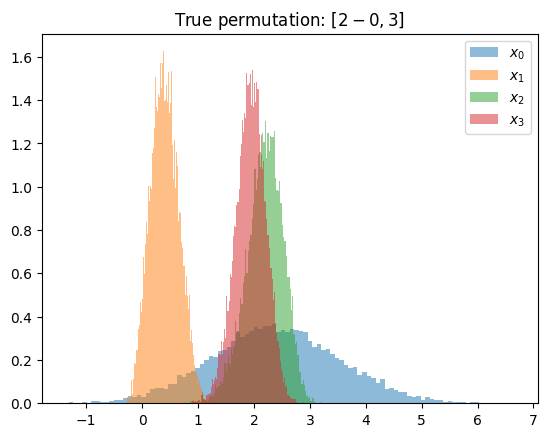

Global seed set to 666


Training with permutation [3, 2, 1, 0], true ordering is [2, 1, 0, 3]
TrainingModule(
  (model): OCDAF(
    (flows): ModuleList(
      (0): MaskedAffineFlow(
        (0): MaskedBlock(
          in_features=4, out_features=4, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): MaskedBlock(
          in_features=4, out_features=4, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (2): MaskedBlock(
          in_features=4, out_features=4, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (3): MaskedBlock(in_features=4, out_features=8, bias=True)
      )
      (1): MaskedAffineFlow(
        (0): MaskedBlock(
          in_features=4, out_features=4, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): MaskedBlock(
          in_features=4, out_features=4, bias=True
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (2): MaskedBlock(
  

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁▁
loss/val,█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁▁
nll/val,█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-5.37813


Global seed set to 666


Training with permutation [2, 3, 1, 0], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▄▄▄▄▄▄▄▄▄▅▄▄▃▃▄▄▄▃▃▄▃▄▃▃▂▂▂▂▁▁▁▁▁▂▁▁▂
loss/val,█▆▅▄▄▄▄▄▄▄▄▄▄▅▄▅▅▄▄▄▃▄▄▃▃▃▃▃▂▂▂▃▃▂▂▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▄▄▄▄▄▄▄▄▄▅▄▄▃▃▄▄▄▃▃▄▃▄▃▃▂▂▂▂▁▁▁▁▁▂▁▁▂
nll/val,█▆▅▄▄▄▄▄▄▄▄▄▄▅▄▅▅▄▄▄▃▄▄▃▃▃▃▃▂▂▂▃▃▂▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-7.40247


Global seed set to 666


Training with permutation [2, 1, 3, 0], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▃▃▃▃▃▃▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▂▁▁
loss/val,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▃▃▃▃▃▃▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▂▁▁
nll/val,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-3.6086


Global seed set to 666


Training with permutation [2, 1, 0, 3], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
loss/val,█▆▄▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
nll/val,█▆▄▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-6.48955


Global seed set to 666


Training with permutation [3, 1, 2, 0], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁
loss/val,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁
nll/val,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-7.997


Global seed set to 666


Training with permutation [1, 3, 2, 0], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/val,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-6.48063


Global seed set to 666


Training with permutation [1, 2, 3, 0], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▄▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▂
loss/val,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▄▃▃▃▃▂▃▂▂▃▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▂
nll/val,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-6.05981


Global seed set to 666


Training with permutation [1, 2, 0, 3], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▅▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/val,█▅▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-2.83409


Global seed set to 666


Training with permutation [3, 1, 0, 2], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▂▁▂▁▁▁▁
loss/val,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▂▁▂▁▁▁▁
nll/val,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-8.32015


Global seed set to 666


Training with permutation [1, 3, 0, 2], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/val,█▅▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-3.27218


Global seed set to 666


Training with permutation [1, 0, 3, 2], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▁▂▁
loss/val,█▆▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▁▂▁
nll/val,█▆▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-8.53751


Global seed set to 666


Training with permutation [1, 0, 2, 3], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁▂
loss/val,█▆▃▃▃▂▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▃▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁▂
nll/val,█▆▃▃▃▂▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▃▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-6.76028


Global seed set to 666


Training with permutation [3, 2, 0, 1], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▄▄▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
loss/val,█▆▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▄▄▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
nll/val,█▆▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-10.14377


Global seed set to 666


Training with permutation [2, 3, 0, 1], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▄▃▃▃▃▃▃▃▂▃▄▂▂▂▂▂▆▄▂▂▃▂▂▂▂▃▇▃▃▂▂▁▁▁▁▂▂▄
loss/val,█▅▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▃▄▄▅▃▃▃▂▃▂▂▄▄▄▁▁▁▁▁▄▁▁▃
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▄▃▃▃▃▃▃▃▂▃▄▂▂▂▂▂▆▄▂▂▃▂▂▂▂▃▇▃▃▂▂▁▁▁▁▂▂▄
nll/val,█▅▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▃▄▄▅▃▃▃▂▃▂▂▄▄▄▁▁▁▁▁▄▁▁▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-0.12197


Global seed set to 666


Training with permutation [2, 0, 3, 1], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/val,█▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-3.38537


Global seed set to 666


Training with permutation [2, 0, 1, 3], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▁▂▁▁
loss/val,█▆▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▁▂▁▁
nll/val,█▆▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-7.60602


Global seed set to 666


Training with permutation [3, 0, 2, 1], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▃▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
loss/val,█▆▃▃▃▃▃▂▂▃▃▃▂▂▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▃▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
nll/val,█▆▃▃▃▃▃▂▂▃▃▃▂▂▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-7.39421


Global seed set to 666


Training with permutation [0, 3, 2, 1], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▄▃▃▃▃▃▃▃▃▃▂▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
loss/val,█▆▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▄▃▃▃▃▃▃▃▃▃▂▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
nll/val,█▆▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-13.05611


Global seed set to 666


Training with permutation [0, 2, 3, 1], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▅▅▅▄▄▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
loss/val,█▅▅▅▅▅▅▅▄▅▅▄▅▅▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▅▅▅▄▄▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
nll/val,█▅▅▅▅▅▅▅▄▅▅▄▅▅▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-11.23719


Global seed set to 666


Training with permutation [0, 2, 1, 3], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁
loss/val,█▆▄▃▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁
nll/val,█▆▄▃▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-6.58746


Global seed set to 666


Training with permutation [3, 0, 1, 2], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▃▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
loss/val,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▃▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
nll/val,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-9.63719


Global seed set to 666


Training with permutation [0, 3, 1, 2], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▆▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/val,█▆▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-10.32458


Global seed set to 666


Training with permutation [0, 1, 3, 2], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▅▄▄▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▂▃▁▁▁▁▁
loss/val,█▆▅▅▅▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▄▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▅▄▄▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▂▃▁▁▁▁▁
nll/val,█▆▅▅▅▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▄▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-10.79636


Global seed set to 666


Training with permutation [0, 1, 2, 3], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▃▁▁
loss/val,█▆▃▃▃▃▃▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▃▁▁
nll/val,█▆▃▃▃▃▃▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-7.88932


In [3]:
# test the simplified model with chain graphs
data_config["dataset_args"]["scm_generator_args"]["graph_generator_args"]['graph_type'] = 'chain'
model_config = yaml.load(open('config/model-simplified.yaml'), Loader=yaml.FullLoader)['init_args']
for i in range(2, 5):
    test_fixed_permutations(i, data_config, model_config, training_config, base_name='chain-512,10k,Adam-nosched')

x(0) = exp(sigmoid(+0.20)) + exp(sigmoid(+0.35)) * N(0.35,0.64)
---------------------
x(1) = exp(sigmoid(x(0)*-0.83+-0.70)) + exp(sigmoid(x(0)*-0.33+-0.54)) * N(-0.54,0.23)
---------------------



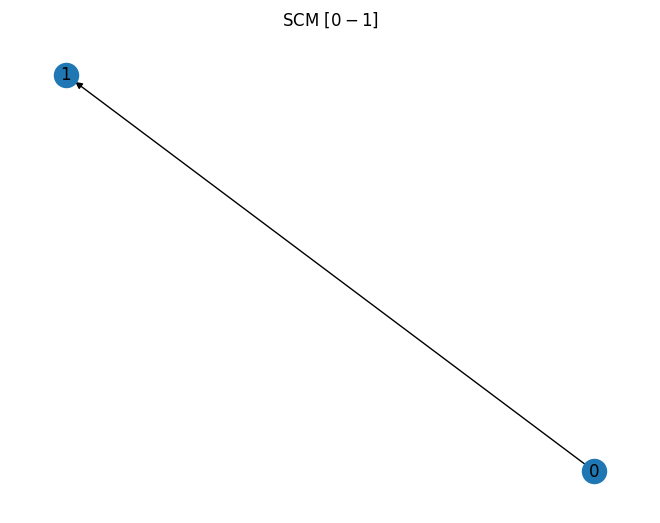

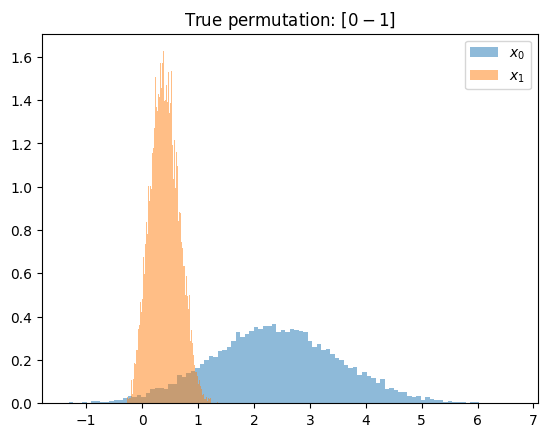

Global seed set to 666


Training with permutation [1, 0], true ordering is [0, 1]
TrainingModule(
  (model): OCDAF(
    (flow): AffineFlow(
      (0): MaskedAffineFlowTransform(
        num_masks=1, seed=0, ordering=tensor([1, 0], dtype=torch.int32)
        (0): MaskedBlock(
          in_features=2, out_features=2, bias=True, ordering=tensor([1, 0], dtype=torch.int32)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): MaskedBlock(
          in_features=2, out_features=2, bias=True, ordering=tensor([1, 0], dtype=torch.int32)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (2): MaskedBlock(
          in_features=2, out_features=2, bias=True, ordering=tensor([1, 0], dtype=torch.int32)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (3): MaskedBlock(in_features=2, out_features=4, bias=True, ordering=tensor([1, 0], dtype=torch.int32))
      )
      (1): MaskedAffineFlowTransform(
        num_masks=1, seed=0, ordering=tensor([1, 0], dtype=

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 90    
--------------------------------
90        Trainable params
0         Non-trainable params
90        Total params
0.000     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▁▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▅▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▁▁▁▁▁▁▁▄▁▂▂▃▂▁▁▂▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▁▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/val,█▅▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▁▁▁▁▁▁▁▄▁▂▂▃▂▁▁▂▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-2.21427


Global seed set to 666


Training with permutation [0, 1], true ordering is [0, 1]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 90    
--------------------------------
90        Trainable params
0         Non-trainable params
90        Total params
0.000     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/val,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-2.38099


x(1) = exp(sigmoid(+0.20)) + exp(sigmoid(+0.35)) * N(0.35,0.64)
---------------------
x(2) = exp(sigmoid(x(1)*-0.83+-0.70)) + exp(sigmoid(x(1)*-0.33+-0.54)) * N(-0.54,0.23)
---------------------
x(0) = exp(sigmoid(x(2)*-0.53+-0.67)) + exp(sigmoid(x(2)*-0.93+0.51)) * N(0.51,0.25)
---------------------



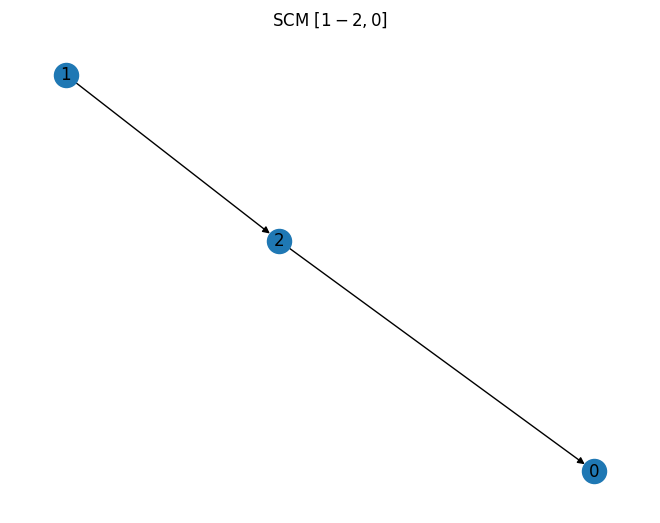

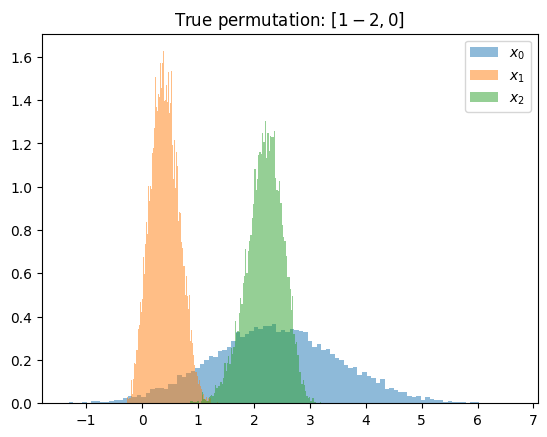

Global seed set to 666


Training with permutation [2, 1, 0], true ordering is [1, 2, 0]
TrainingModule(
  (model): OCDAF(
    (flow): AffineFlow(
      (0): MaskedAffineFlowTransform(
        num_masks=1, seed=0, ordering=tensor([2, 1, 0], dtype=torch.int32)
        (0): MaskedBlock(
          in_features=3, out_features=3, bias=True, ordering=tensor([2, 1, 0], dtype=torch.int32)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): MaskedBlock(
          in_features=3, out_features=3, bias=True, ordering=tensor([2, 1, 0], dtype=torch.int32)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (2): MaskedBlock(
          in_features=3, out_features=3, bias=True, ordering=tensor([2, 1, 0], dtype=torch.int32)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (3): MaskedBlock(in_features=3, out_features=6, bias=True, ordering=tensor([2, 1, 0], dtype=torch.int32))
      )
      (1): MaskedAffineFlowTransform(
        num_masks=1, seed=0, ordering=

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 180   
--------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▆▃▂▂▂▂▂▁▂▂▂▂▁▁▂▁▂▂▂▁▁▂▂▂▂▁▁▁▂▂▁▂▂▁▁▂▂▁▂
loss/val,█▇▄▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▁▂▂▁▂▁▁▂▁▂▂▁▂▁▂▂
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▆▃▂▂▂▂▂▁▂▂▂▂▁▁▂▁▂▂▂▁▁▂▂▂▂▁▁▁▂▂▁▂▂▁▁▂▂▁▂
nll/val,█▇▄▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▁▂▂▁▂▁▁▂▁▂▂▁▂▁▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-2.81973


Global seed set to 666


Training with permutation [1, 2, 0], true ordering is [1, 2, 0]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 180   
--------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁
loss/val,█▅▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁
nll/val,█▅▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-3.35022


Global seed set to 666


Training with permutation [1, 0, 2], true ordering is [1, 2, 0]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 180   
--------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▆▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/val,█▆▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-3.67872


Global seed set to 666


Training with permutation [2, 0, 1], true ordering is [1, 2, 0]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 180   
--------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▆▅▄▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▃▁▁▁▁▁
loss/val,█▇▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▆▅▄▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▃▁▁▁▁▁
nll/val,█▇▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-5.53869


Global seed set to 666


Training with permutation [0, 2, 1], true ordering is [1, 2, 0]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 180   
--------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▁▂▁▁▁▂▂▁▁▁
loss/val,█▆▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▂▂▂▂▂▂▂▁▂▃▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▁▂▁▁▁▂▂▁▁▁
nll/val,█▆▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▂▂▂▂▂▂▂▁▂▃▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-5.57026


Global seed set to 666


Training with permutation [0, 1, 2], true ordering is [1, 2, 0]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 180   
--------------------------------
180       Trainable params
0         Non-trainable params
180       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▃▃▃▃▃▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁
loss/val,█▆▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▃▃▃▃▃▃▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁
nll/val,█▆▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-7.27864


x(2) = exp(sigmoid(+0.20)) + exp(sigmoid(+0.35)) * N(0.35,0.64)
---------------------
x(1) = exp(sigmoid(x(2)*-0.83+-0.70)) + exp(sigmoid(x(2)*-0.33+-0.54)) * N(-0.54,0.23)
---------------------
x(0) = exp(sigmoid(x(1)*-0.53+-0.67)) + exp(sigmoid(x(1)*-0.93+0.51)) * N(0.51,0.25)
---------------------
x(3) = exp(sigmoid(x(0)*0.22+-0.77)) + exp(sigmoid(x(0)*-0.66+0.32)) * N(0.32,0.20)
---------------------



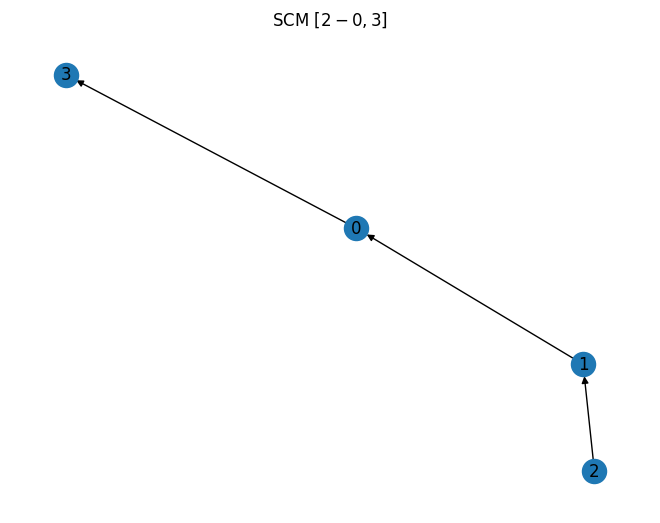

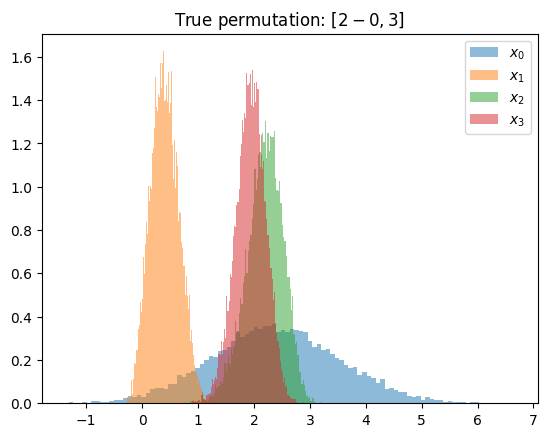

Global seed set to 666


Training with permutation [3, 2, 1, 0], true ordering is [2, 1, 0, 3]
TrainingModule(
  (model): OCDAF(
    (flow): AffineFlow(
      (0): MaskedAffineFlowTransform(
        num_masks=1, seed=0, ordering=tensor([3, 2, 1, 0], dtype=torch.int32)
        (0): MaskedBlock(
          in_features=4, out_features=4, bias=True, ordering=tensor([3, 2, 1, 0], dtype=torch.int32)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (1): MaskedBlock(
          in_features=4, out_features=4, bias=True, ordering=tensor([3, 2, 1, 0], dtype=torch.int32)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (2): MaskedBlock(
          in_features=4, out_features=4, bias=True, ordering=tensor([3, 2, 1, 0], dtype=torch.int32)
          (activation): LeakyReLU(negative_slope=0.01)
        )
        (3): MaskedBlock(in_features=4, out_features=8, bias=True, ordering=tensor([3, 2, 1, 0], dtype=torch.int32))
      )
      (1): MaskedAffineFlowTransform(
        num_masks

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁
loss/val,█▅▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁
nll/val,█▅▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-5.34336


Global seed set to 666


Training with permutation [2, 3, 1, 0], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▄▃▃▂▂▂▂▂▂▁▁▁▂▁▁
loss/val,█▆▅▅▄▄▄▄▄▄▅▄▄▄▅▅▄▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▄▃▃▂▂▂▂▂▂▁▁▁▂▁▁
nll/val,█▆▅▅▄▄▄▄▄▄▅▄▄▄▅▅▄▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-9.86103


Global seed set to 666


Training with permutation [2, 1, 3, 0], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁
loss/val,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁
nll/val,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-2.99302


Global seed set to 666


Training with permutation [2, 1, 0, 3], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▃▃▃▂▂▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁
loss/val,█▆▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▃▃▃▂▂▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁
nll/val,█▆▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-5.56676


Global seed set to 666


Training with permutation [3, 1, 2, 0], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
loss/val,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
nll/val,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-7.92334


Global seed set to 666


Training with permutation [1, 3, 2, 0], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
loss/val,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁
nll/val,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-6.74459


Global seed set to 666


Training with permutation [1, 2, 3, 0], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▃▂▁▁▁▁▁
loss/val,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▁▁▁▃▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▃▂▁▁▁▁▁
nll/val,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▁▁▁▃▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-7.26774


Global seed set to 666


Training with permutation [1, 2, 0, 3], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/val,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/val,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-2.396


Global seed set to 666


Training with permutation [3, 1, 0, 2], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▂▁▁▁
loss/val,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▂▁▁▁
nll/val,█▆▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-6.85271


Global seed set to 666


Training with permutation [1, 3, 0, 2], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁
loss/val,█▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁
nll/val,█▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-4.66508


Global seed set to 666


Training with permutation [1, 0, 3, 2], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▄▂
loss/val,█▆▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▄▂
nll/val,█▆▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-8.31179


Global seed set to 666


Training with permutation [1, 0, 2, 3], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▂
loss/val,█▆▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▂
nll/val,█▆▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-6.74512


Global seed set to 666


Training with permutation [3, 2, 0, 1], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▁▁▁▁▁▁▁
loss/val,█▆▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▂▁▁▁▁▁▁▁
nll/val,█▆▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-9.50466


Global seed set to 666


Training with permutation [2, 3, 0, 1], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▃▂▃▃▂▄▃▂▄▂▂▂▂▂▁▁▃▁▁▁▂▂▁
loss/val,█▅▄▄▄▃▃▃▃▃▂▃▂▂▃▃▃▃▂▃▃▃▂▃▂▄▃▅▂▂▁▁▁▁▁▁▁▂▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▃▂▃▃▂▄▃▂▄▂▂▂▂▂▁▁▃▁▁▁▂▂▁
nll/val,█▅▄▄▄▃▃▃▃▃▂▃▂▂▃▃▃▃▂▃▃▃▂▃▂▄▃▅▂▂▁▁▁▁▁▁▁▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-5.47814


Global seed set to 666


Training with permutation [2, 0, 3, 1], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁
loss/val,█▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁
nll/val,█▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-3.67536


Global seed set to 666


Training with permutation [2, 0, 1, 3], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁
loss/val,█▆▄▄▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▁▁
nll/val,█▆▄▄▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-7.0661


Global seed set to 666


Training with permutation [3, 0, 2, 1], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▃▃▃▂▂▂▂▂▄▄▄▃▃▃▃▃▃▃▃▂▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁
loss/val,█▆▄▃▃▂▂▂▃▂▂▄▄▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▃▃▃▂▂▂▂▂▄▄▄▃▃▃▃▃▃▃▃▂▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁
nll/val,█▆▄▃▃▂▂▂▃▂▂▄▄▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-7.06599


Global seed set to 666


Training with permutation [0, 3, 2, 1], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
loss/val,█▆▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
nll/val,█▆▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-13.01003


Global seed set to 666


Training with permutation [0, 2, 3, 1], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▅▅▅▄▅▅▄▄▄▅▄▅▄▄▄▄▄▄▄▄▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁
loss/val,█▅▅▅▅▅▅▅▅▄▅▄▅▅▄▄▄▄▄▄▄▄▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▅▅▅▄▅▅▄▄▄▅▄▅▄▄▄▄▄▄▄▄▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁
nll/val,█▅▅▅▅▅▅▅▅▄▅▄▅▅▄▄▄▄▄▄▄▄▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-11.80947


Global seed set to 666


Training with permutation [0, 2, 1, 3], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▃▁▂
loss/val,█▆▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▃▁▂
nll/val,█▆▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-6.81438


Global seed set to 666


Training with permutation [3, 0, 1, 2], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▂▂▁▂▂▁▁▂▁▁▂▂
loss/val,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▁▁▁▁▁▁▂▂▁▂▂▁▁▂▁▁▂▂
nll/val,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-8.93776


Global seed set to 666


Training with permutation [0, 3, 1, 2], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
loss/val,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
nll/val,█▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-9.74989


Global seed set to 666


Training with permutation [0, 1, 3, 2], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▅▅▄▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▂▁▂▁▁▁▁▁▁
loss/val,█▆▅▅▅▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▅▅▄▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▂▁▂▁▁▁▁▁▁
nll/val,█▆▅▅▅▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-9.95743


Global seed set to 666


Training with permutation [0, 1, 2, 3], true ordering is [2, 1, 0, 3]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type  | Params
--------------------------------
0 | model | OCDAF | 300   
--------------------------------
300       Trainable params
0         Non-trainable params
300       Total params
0.001     Total estimated model params size (MB)
/Users/vahidzee/.pyenv/versions/3.10.9/envs/deep/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cp

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
factors/nll/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/train,█▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁
loss/val,█▆▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nll/train,█▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁
nll/val,█▆▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch,599
factors/nll/val,1.0
loss/train,-8.13041


In [4]:
# test the simplified model with chain graphs
data_config["dataset_args"]["scm_generator_args"]["graph_generator_args"]['graph_type'] = 'chain'
model_config = yaml.load(open('config/model.yaml'), Loader=yaml.FullLoader)['init_args']
for i in range(2, 5):
    test_fixed_permutations(i, data_config, model_config, training_config, base_name='chain-512,10k,Adam-old')